# Preprocessing of Datasets

In [10]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
#df=pd.read_table(r"C:\\Users\\srika\\OneDrive\\Desktop\\Fall19\\DeepLearningForNLP\\Assignment2\\stanfordSentimentTreebank\\stanfordSentimentTreebank\\datasetSentences.txt")

In [12]:
snippet_file  = 'original_rt_snippets.txt'
positive_file = 'rt-polarity_pos.pos'
negative_file = 'rt-polarity_neg.neg'
sentences_for_data = pd.read_csv('datasetSentences.txt',sep = "\t",header = 0)
splitdata = pd.read_csv('datasetSplit.txt', delimiter = ",", header = 0)

In [13]:
snippet_file_list = []
filesnippet = open("original_snipp.txt","w+")
filesnippet.seek(0)
filesnippet.truncate()
with open(snippet_file, 'rt', encoding = 'latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()                     
        each_line = re.sub('<.*?>', '',each_line) 
        each_line = re.sub('<[a-zA-Z]','',each_line)      
        each_line = re.sub(r'[^\w]','',each_line)         
        each_line = re.sub(r'[0-9]','',each_line)
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)  
        snippet_file_list.append(each_line)
        filesnippet.write(each_line+"\n")
filesnippet.close()

In [14]:
positivefile=[]
fileforpositive = open("Positive_Labels.txt","w+")
fileforpositive.seek(0)
fileforpositive.truncate()
with open(positive_file,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()                     
        each_line = re.sub('<.*?>', '',each_line)         
        each_line = re.sub('<[a-zA-Z]','',each_line)      
        each_line = re.sub(r'[^\w]','',each_line)
        each_line = re.sub(r'[0-9]','',each_line)         
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)  # removes non ascii characters
        positivefile.append(each_line)
        fileforpositive.write(each_line+"\n")
fileforpositive.close()

In [15]:
negativefile=[]
filefornegative = open("negative_labels.txt","w+")
filefornegative.seek(0)
filefornegative.truncate()
with open(negative_file,'rt',encoding='latin-1') as f:
    for each_line in f:
        each_line = each_line.lower()
        each_line = re.sub('<.*?>', '',each_line)
        each_line = re.sub('<[a-zA-Z]','',each_line)        
        each_line = re.sub(r'[^\w]','',each_line)
        each_line = re.sub(r'[0-9]','',each_line)
        each_line = re.sub(r'[^\x00-\x7f]','',each_line)
        negativefile.append(each_line)
        filefornegative.write(each_line+"\n")
filefornegative.close()

In [16]:
labels_for_test = []
for line in snippet_file_list:
    if any(line == text for text in positivefile):
        labels_for_test.append(1)
    elif any(line == text for text in negativefile):
        labels_for_test.append(0)
    #Through by lot of preprocessing process we get to know that there is one sentence which doesn't belong to any of the files 
    elif line =="ihavenoproblemwithdifficultmoviesormoviesthatasktheaudiencetomeetthemhalfwayandconnectthedotsinsteadofhavingthingsallspelledoutbutfirstyouhavetogivetheaudienceareasontowanttoputforthateffort" :
        labels_for_test.append(0)
    else:
        print (line )

In [17]:
def IndexPositionWithOriginalFile(each_sentence, original_snippet_sentences):
    for indexposition in range(len(original_snippet_sentences)):
        if each_sentence in original_snippet_sentences[indexposition]:
            return indexposition 

In [18]:
def filtering_sentence(each_sentence):
    each_sentence= each_sentence.lower()
    each_sentence = re.sub(r'[^\w]','',each_sentence)
    each_sentence = re.sub(r'[0-9]','',each_sentence)
    each_sentence = re.sub(r'[^\x00-\x7f]','',each_sentence)
    each_sentence = each_sentence.replace("lrb", "")
    each_sentence = each_sentence.replace("rrb","")
    return each_sentence


In [19]:
labels=[]
filefordataset = open("dataset.txt","w+")
for each_sentence in list(sentences_for_data["sentence"].values):
    each_sentence= filtering_sentence(each_sentence)
    filefordataset.write(each_sentence+"\n")
    index = IndexPositionWithOriginalFile(each_sentence,snippet_file_list)
    labels.append(labels_for_test[index])
    snippet_file_list[index]= snippet_file_list[index].replace(each_sentence,"$$",1)  # Removes the sentence that has been matched already to avoid confusion and match with the correct original_snippet when same set of characters appear again.
filefordataset.close()
sentences_for_data["labels"]=labels

In [20]:
sentences_for_data['labels']

0        1
1        1
2        1
3        1
4        1
        ..
11850    0
11851    0
11852    1
11853    0
11854    0
Name: labels, Length: 11855, dtype: int64

In [21]:
len(splitdata)

11855

In [22]:
len(sentences_for_data)

11855

# Creating word embeddings

In [23]:
listoftexts,listwords=[],[]
for line in sentences_for_data['sentence']:
        exclude = set(string.punctuation)
        line = ''.join(ch for ch in line if ch not in exclude)
        listwords=[]
        for word in line.split():
            listwords.append(word)
        listoftexts.append(listwords)

In [24]:
train_indexes,test_indexes,dev_indexes=[],[],[]
for k,i in enumerate(splitdata['splitset_label']):
    if i==1:
        train_indexes.append(k+1)
    if i==2:
        test_indexes.append(k+1)
    if i==3:
        dev_indexes.append(k+1)


In [25]:
all_labels=[]
for i in sentences_for_data['labels']:
    all_labels.append(i)  


In [26]:
y_train,y_dev,y_test=[],[],[]
for i in train_indexes:
    y_train.append(all_labels[i-1])
for i in dev_indexes:
    y_dev.append(all_labels[i-1])
for i in test_indexes:
    y_test.append(all_labels[i-1])

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(listoftexts)
sequences = tokenizer.texts_to_sequences(listoftexts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)

Found 19377 unique tokens.


In [28]:
X_train,X_dev,X_test=[],[],[]
for i in train_indexes:
    X_train.append(list(data[i-1]))
for i in dev_indexes:
    X_dev.append(list(data[i-1]))
for i in test_indexes:
    X_test.append(list(data[i-1]))

In [29]:
embeddings_index = {}
f = open(r'C:\Users\srika\OneDrive\Desktop\Fall19\DeepLearningForNLP\Assignment2\glove.6B.300d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [31]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=52,
                            trainable=False,mask_zero=True)

# Implementation of RNN,LSTM and GRU

In [32]:
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation,LSTM, GRU
from keras import optimizers
def RNN(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(SimpleRNN(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [33]:
def LSTMfunction(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [34]:
def GRUfunction(wordvector_dim,embedding_matrix,sequence_length,learning_rate,hiddenUnits):
    model=Sequential()
    model.add(embedding_layer)
    model.add(GRU(units=hiddenUnits,input_shape=[None,sequence_length],return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    adam=optimizers.Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    print(model.summary())
    return model

In [274]:
RNN_model=RNN(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, 100)               40100     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 5,853,601
Trainable params: 40,201
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [275]:
history=RNN_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 9s 1ms/step - loss: 0.6991 - accuracy: 0.5529 - val_loss: 0.6337 - val_accuracy: 0.6440
Epoch 2/5
8544/8544 [==============================] - 8s 985us/step - loss: 0.5952 - accuracy: 0.6845 - val_loss: 0.5480 - val_accuracy: 0.7221
Epoch 3/5
8544/8544 [==============================] - 9s 1ms/step - loss: 0.5394 - accuracy: 0.7317 - val_loss: 0.5200 - val_accuracy: 0.7348
Epoch 4/5
8544/8544 [==============================] - 8s 962us/step - loss: 0.5004 - accuracy: 0.7582 - val_loss: 0.5161 - val_accuracy: 0.7366
Epoch 5/5
8544/8544 [==============================] - 8s 970us/step - loss: 0.4798 - accuracy: 0.7701 - val_loss: 0.5135 - val_accuracy: 0.7375


In [261]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.622443,0.680291,0.677806,0.583684
1,0.530982,0.733878,0.567926,0.698619
2,0.534392,0.739328,0.514090,0.745669
3,0.521201,0.740236,0.498719,0.755267
4,0.530590,0.746594,0.481671,0.767205


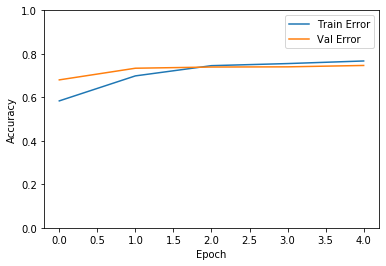

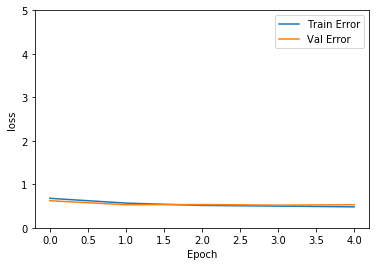

In [262]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)



In [278]:
LSTM_model=LSTMfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 101       
Total params: 5,973,901
Trainable params: 160,501
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [279]:
history=LSTM_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 19s 2ms/step - loss: 0.6401 - accuracy: 0.6412 - val_loss: 0.5546 - val_accuracy: 0.7221
Epoch 2/5
8544/8544 [==============================] - 19s 2ms/step - loss: 0.5375 - accuracy: 0.7323 - val_loss: 0.5096 - val_accuracy: 0.7520
Epoch 3/5
8544/8544 [==============================] - 18s 2ms/step - loss: 0.5061 - accuracy: 0.7519 - val_loss: 0.5000 - val_accuracy: 0.7557
Epoch 4/5
8544/8544 [==============================] - 21s 2ms/step - loss: 0.4834 - accuracy: 0.7626 - val_loss: 0.4919 - val_accuracy: 0.7684
Epoch 5/5
8544/8544 [==============================] - 21s 2ms/step - loss: 0.4667 - accuracy: 0.7773 - val_loss: 0.4989 - val_accuracy: 0.7693


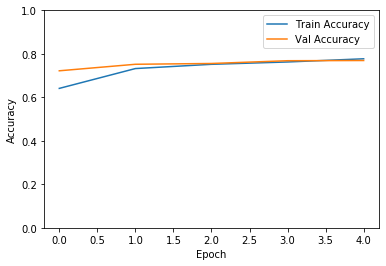

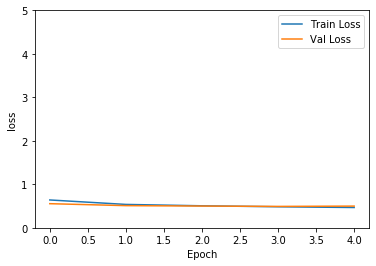

In [280]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)


In [281]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_5 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 5,933,801
Trainable params: 120,401
Non-trainable params: 5,813,400
_________________________________________________________________
None


#Best Model

In [282]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 22s 3ms/step - loss: 0.6601 - accuracy: 0.6007 - val_loss: 0.6145 - val_accuracy: 0.6803
Epoch 2/5
8544/8544 [==============================] - 23s 3ms/step - loss: 0.5837 - accuracy: 0.6976 - val_loss: 0.5209 - val_accuracy: 0.7411
Epoch 3/5
8544/8544 [==============================] - 26s 3ms/step - loss: 0.5231 - accuracy: 0.7408 - val_loss: 0.5001 - val_accuracy: 0.7648
Epoch 4/5
8544/8544 [==============================] - 21s 3ms/step - loss: 0.4937 - accuracy: 0.7575 - val_loss: 0.4939 - val_accuracy: 0.7693
Epoch 5/5
8544/8544 [==============================] - 22s 3ms/step - loss: 0.4721 - accuracy: 0.7707 - val_loss: 0.4822 - val_accuracy: 0.7738


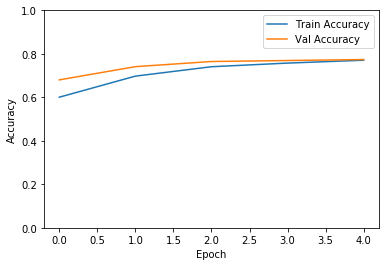

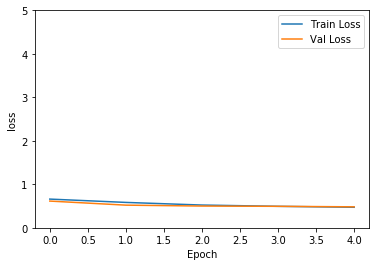

In [283]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)


After performing lot of changes on parameters I get to know that these are the best parameters that too in GRU model the validation accuracy is 78.56 in the 5 epoch. so, In my opinion considering GRU model is the best model among all those.

# Experimenting with Network Structure

Using hidden state in the last word in the sentence:
    while we are tuning the parameter's by default in my model return sequences is given as false
    that means in every hidden state the output is not returning but where as in return sequences False 
    it returns only in the last word the hidden sequence.

Doubling the hidden units

In [284]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=200)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_6 (GRU)                  (None, 200)               300600    
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 201       
Total params: 6,114,201
Trainable params: 300,801
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [285]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 39s 5ms/step - loss: 0.6459 - accuracy: 0.6204 - val_loss: 0.5866 - val_accuracy: 0.6948
Epoch 2/5
8544/8544 [==============================] - 38s 4ms/step - loss: 0.5596 - accuracy: 0.7081 - val_loss: 0.5246 - val_accuracy: 0.7411
Epoch 3/5
8544/8544 [==============================] - 40s 5ms/step - loss: 0.5047 - accuracy: 0.7534 - val_loss: 0.5018 - val_accuracy: 0.7729
Epoch 4/5
8544/8544 [==============================] - 37s 4ms/step - loss: 0.4816 - accuracy: 0.7658 - val_loss: 0.4877 - val_accuracy: 0.7648
Epoch 5/5
8544/8544 [==============================] - 39s 5ms/step - loss: 0.4647 - accuracy: 0.7749 - val_loss: 0.4842 - val_accuracy: 0.7729


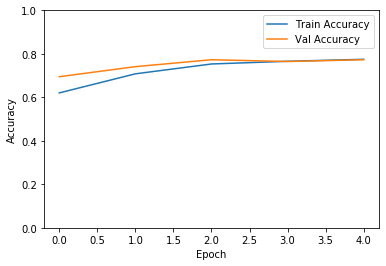

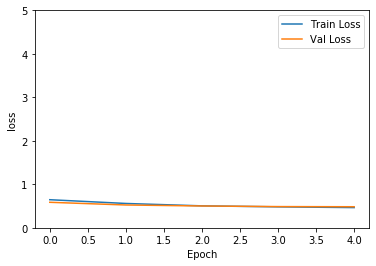

In [287]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)


Halving the hiddenunits

In [271]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=50)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_3 (GRU)                  (None, 200)               300600    
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 201       
Total params: 6,114,201
Trainable params: 300,801
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [272]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 28s 3ms/step - loss: 0.6356 - accuracy: 0.6317 - val_loss: 0.5520 - val_accuracy: 0.7112
Epoch 2/5
8544/8544 [==============================] - 27s 3ms/step - loss: 0.5306 - accuracy: 0.7354 - val_loss: 0.5093 - val_accuracy: 0.7548
Epoch 3/5
8544/8544 [==============================] - 25s 3ms/step - loss: 0.4955 - accuracy: 0.7581 - val_loss: 0.4882 - val_accuracy: 0.7584
Epoch 4/5
8544/8544 [==============================] - 28s 3ms/step - loss: 0.4788 - accuracy: 0.7699 - val_loss: 0.4796 - val_accuracy: 0.7702
Epoch 5/5
8544/8544 [==============================] - 28s 3ms/step - loss: 0.4539 - accuracy: 0.7794 - val_loss: 0.4730 - val_accuracy: 0.7766


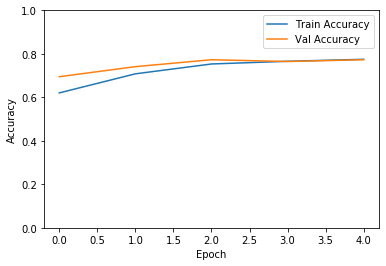

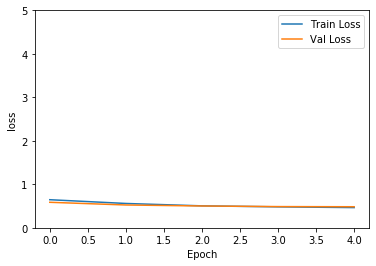

In [288]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

In the Doubling of hidden units in GRU model when we check for Train Accuracy and val Accuracy in the initial epochs train Accuracy is less than validation Accuracy.When we take less hidden units as the hidden units are less than the accuracy is more when the epoch's gets increased where as the contradictory sentence applies in the other and mostly to select 100 hiddenunits is optimal 

Doubling the sequence length

In [289]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=100,learning_rate=0.001,hiddenUnits=50)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_7 (GRU)                  (None, 50)                52650     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 5,866,101
Trainable params: 52,701
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [290]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 17s 2ms/step - loss: 0.6645 - accuracy: 0.5912 - val_loss: 0.6269 - val_accuracy: 0.6485
Epoch 2/5
8544/8544 [==============================] - 17s 2ms/step - loss: 0.6134 - accuracy: 0.6641 - val_loss: 0.5823 - val_accuracy: 0.6975
Epoch 3/5
8544/8544 [==============================] - 16s 2ms/step - loss: 0.5513 - accuracy: 0.7178 - val_loss: 0.5071 - val_accuracy: 0.7520
Epoch 4/5
8544/8544 [==============================] - 16s 2ms/step - loss: 0.5019 - accuracy: 0.7575 - val_loss: 0.4951 - val_accuracy: 0.7629
Epoch 5/5
8544/8544 [==============================] - 17s 2ms/step - loss: 0.4798 - accuracy: 0.7697 - val_loss: 0.4947 - val_accuracy: 0.7702


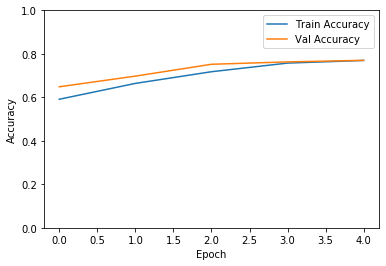

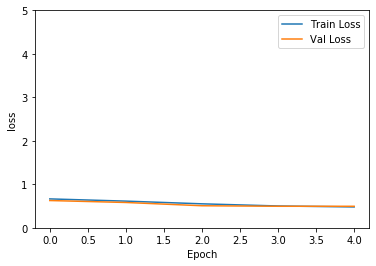

In [291]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

Halving the sequence length

In [294]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=25,learning_rate=0.001,hiddenUnits=50)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_9 (GRU)                  (None, 50)                52650     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 5,866,101
Trainable params: 52,701
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [295]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 13s 2ms/step - loss: 0.6739 - accuracy: 0.5734 - val_loss: 0.6336 - val_accuracy: 0.6267
Epoch 2/5
8544/8544 [==============================] - 13s 2ms/step - loss: 0.6109 - accuracy: 0.6681 - val_loss: 0.5660 - val_accuracy: 0.7148
Epoch 3/5
8544/8544 [==============================] - 14s 2ms/step - loss: 0.5395 - accuracy: 0.7264 - val_loss: 0.5077 - val_accuracy: 0.7520
Epoch 4/5
8544/8544 [==============================] - 15s 2ms/step - loss: 0.4961 - accuracy: 0.7574 - val_loss: 0.4956 - val_accuracy: 0.7520
Epoch 5/5
8544/8544 [==============================] - 14s 2ms/step - loss: 0.4786 - accuracy: 0.7699 - val_loss: 0.5021 - val_accuracy: 0.7648


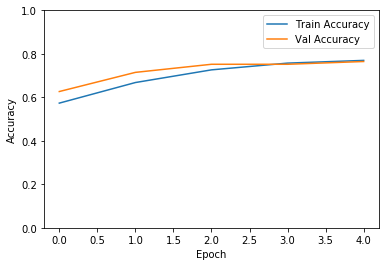

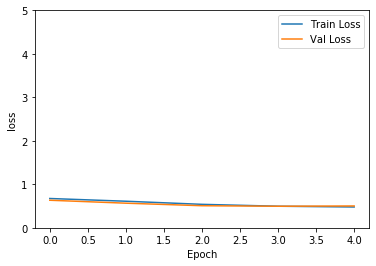

In [296]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

In both the cases there isn't much change between them and as we observe the loss is almost same when we take for different sequence lengths and is almost same in Accuracy as well but the optimal one we find out when we have taken 50 as the sequence length as we are doing padding there won't be huge change when we change seqence length as it gets normalized.

Different Word Embeddings:
As we have already done with 300D.We can ignore that

Word Embeddings 50d

In [298]:
embeddings_index = {}
f = open(r'C:\Users\srika\OneDrive\Desktop\Fall19\DeepLearningForNLP\Assignment2\glove.6B.50d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [306]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [302]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            50,
                            weights=[embedding_matrix],
                            input_length=52,
                            trainable=False,mask_zero=True)

In [303]:
GRU_model=GRUfunction(wordvector_dim=50,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 52, 50)            968900    
_________________________________________________________________
gru_10 (GRU)                 (None, 100)               45300     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 1,014,301
Trainable params: 45,401
Non-trainable params: 968,900
_________________________________________________________________
None


In [304]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 29s 3ms/step - loss: 0.6737 - accuracy: 0.5775 - val_loss: 0.6487 - val_accuracy: 0.6285
Epoch 2/5
8544/8544 [==============================] - 27s 3ms/step - loss: 0.6347 - accuracy: 0.6452 - val_loss: 0.6048 - val_accuracy: 0.6848
Epoch 3/5
8544/8544 [==============================] - 30s 4ms/step - loss: 0.6057 - accuracy: 0.6797 - val_loss: 0.5808 - val_accuracy: 0.7012
Epoch 4/5
8544/8544 [==============================] - 27s 3ms/step - loss: 0.5812 - accuracy: 0.6976 - val_loss: 0.5684 - val_accuracy: 0.7066
Epoch 5/5
8544/8544 [==============================] - 27s 3ms/step - loss: 0.5706 - accuracy: 0.7068 - val_loss: 0.5609 - val_accuracy: 0.7193


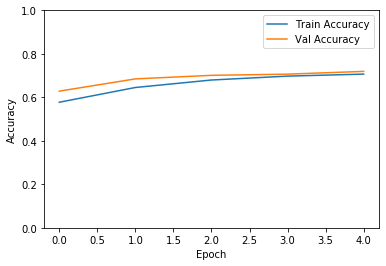

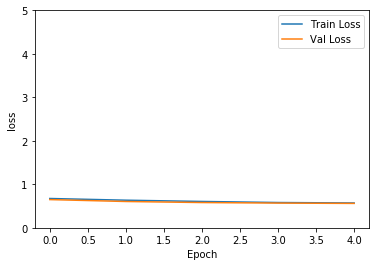

In [305]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

In [311]:
embeddings_index = {}
f = open(r'C:\Users\srika\OneDrive\Desktop\Fall19\DeepLearningForNLP\Assignment2\glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [312]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [313]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=52,
                            trainable=False,mask_zero=True)

In [314]:
GRU_model=GRUfunction(wordvector_dim=100,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 52, 100)           1937800   
_________________________________________________________________
gru_11 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 1,998,201
Trainable params: 60,401
Non-trainable params: 1,937,800
_________________________________________________________________
None


In [315]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 33s 4ms/step - loss: 0.6753 - accuracy: 0.5721 - val_loss: 0.6396 - val_accuracy: 0.6367
Epoch 2/5
8544/8544 [==============================] - 32s 4ms/step - loss: 0.6292 - accuracy: 0.6464 - val_loss: 0.5779 - val_accuracy: 0.6994
Epoch 3/5
8544/8544 [==============================] - 31s 4ms/step - loss: 0.5794 - accuracy: 0.7042 - val_loss: 0.5465 - val_accuracy: 0.7321
Epoch 4/5
8544/8544 [==============================] - 32s 4ms/step - loss: 0.5507 - accuracy: 0.7213 - val_loss: 0.5285 - val_accuracy: 0.7330
Epoch 5/5
8544/8544 [==============================] - 32s 4ms/step - loss: 0.5344 - accuracy: 0.7343 - val_loss: 0.5217 - val_accuracy: 0.7339


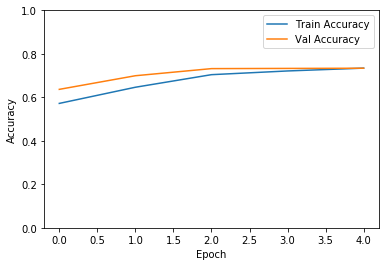

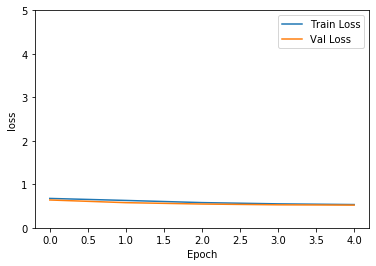

In [316]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_history(history):
    
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.plot(hist['epoch'], hist['accuracy'],
               label='Train Accuracy')
      plt.plot(hist['epoch'], hist['val_accuracy'],
               label = 'Val Accuracy')
      plt.ylim([0,1])
      plt.legend()

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('loss')
      plt.plot(hist['epoch'], hist['loss'],
               label='Train Loss')
      plt.plot(hist['epoch'], hist['val_loss'],
               label = 'Val Loss')
      plt.ylim([0,5])
      plt.legend()

      plt.show()
plot_history(history)

As we check from different Global word co-occurance matrices for 50 dimension,100 dimension, and 300 dimension. The validation accuracy increases from lower dimensional matrix to higher dimensional matrix.The validation accuracy for 300 dimension is more because it best represents the word. So, It automatically best represents the sentnce as well. Almost loss is also same in both because through glove word embeddings the data can be represented in the best way.Basically Glove representation basically concentrates more on analogy tasks such as similar matrices. 

# Evaluating the Model

# Best RNN model

In [35]:
RNN_model=RNN(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.001,hiddenUnits=100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 5,853,601
Trainable params: 40,201
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [36]:
history=RNN_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 4s 475us/step - loss: 0.6691 - accuracy: 0.5839 - val_loss: 0.5815 - val_accuracy: 0.7003
Epoch 2/5
8544/8544 [==============================] - 3s 367us/step - loss: 0.5714 - accuracy: 0.6992 - val_loss: 0.5687 - val_accuracy: 0.7130
Epoch 3/5
8544/8544 [==============================] - 3s 336us/step - loss: 0.5218 - accuracy: 0.7431 - val_loss: 0.5303 - val_accuracy: 0.7393
Epoch 4/5
8544/8544 [==============================] - 3s 405us/step - loss: 0.4964 - accuracy: 0.7571 - val_loss: 0.5185 - val_accuracy: 0.7484
Epoch 5/5
8544/8544 [==============================] - 3s 390us/step - loss: 0.4816 - accuracy: 0.7690 - val_loss: 0.5174 - val_accuracy: 0.7430


In [323]:
score,accuracy=RNN_model.evaluate(np.array(X_test),np.array(y_test),batch_size=512)

2210/2210 [==============================] - 5s 2ms/step


In [38]:
y_pred=RNN_model.predict_classes(np.array(X_test),verbose=1)

2210/2210 [==============================] - 1s 319us/step


In [39]:
y_final_pred=[]
for i in y_pred:
    for j in i:
        y_final_pred.append(j)

In [41]:
from sklearn.metrics import recall_score,f1_score,precision_score
recall_score_RNN=recall_score(y_test, y_final_pred, average='macro')
f1_score_RNN=f1_score(y_test,y_final_pred,average='macro')
precision_score_RNN=precision_score(y_test,y_final_pred,average='macro')

Precision,Recall and F1-score

In [43]:
print(recall_score_RNN,f1_score_RNN,precision_score_RNN)

0.742188934501482 0.7423711671123028 0.7430928089517854


# Best LSTM model

In [44]:
LSTM_model=LSTMfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=60,learning_rate=0.002,hiddenUnits=100)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 5,973,901
Trainable params: 160,501
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [46]:
history=LSTM_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 10s 1ms/step - loss: 0.6368 - accuracy: 0.6284 - val_loss: 0.5319 - val_accuracy: 0.7430
Epoch 2/5
8544/8544 [==============================] - 9s 1ms/step - loss: 0.5317 - accuracy: 0.7328 - val_loss: 0.5127 - val_accuracy: 0.7520
Epoch 3/5
8544/8544 [==============================] - 15s 2ms/step - loss: 0.4915 - accuracy: 0.7543 - val_loss: 0.4833 - val_accuracy: 0.7657
Epoch 4/5
8544/8544 [==============================] - 11s 1ms/step - loss: 0.4627 - accuracy: 0.7765 - val_loss: 0.4808 - val_accuracy: 0.7666
Epoch 5/5
8544/8544 [==============================] - 13s 2ms/step - loss: 0.4385 - accuracy: 0.7912 - val_loss: 0.5030 - val_accuracy: 0.7629


In [47]:
y_pred=LSTM_model.predict_classes(np.array(X_test),verbose=1)

2210/2210 [==============================] - 2s 978us/step


In [48]:
y_final_pred=[]
for i in y_pred:
    for j in i:
        y_final_pred.append(j)

In [51]:
from sklearn.metrics import recall_score,f1_score,precision_score
recall_score_LSTM=recall_score(y_test, y_final_pred, average='macro')
f1_score_LSTM=f1_score(y_test,y_final_pred,average='macro')
precision_score_LSTM=precision_score(y_test,y_final_pred,average='macro')

In [52]:
print(recall_score_LSTM,f1_score_LSTM,precision_score_LSTM)

0.7542289103690685 0.7521720082519812 0.7566387059457286


# Best Model for GRU

In [56]:
GRU_model=GRUfunction(wordvector_dim=300,embedding_matrix=embedding_matrix,sequence_length=50,learning_rate=0.002,hiddenUnits=100)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 300)           5813400   
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 5,933,801
Trainable params: 120,401
Non-trainable params: 5,813,400
_________________________________________________________________
None


In [57]:
history=GRU_model.fit(np.array(X_train),np.array(y_train),batch_size=512,epochs=5,validation_data=(np.array(X_dev),np.array(y_dev)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 9s 1ms/step - loss: 0.6369 - accuracy: 0.6214 - val_loss: 0.5599 - val_accuracy: 0.7148
Epoch 2/5
8544/8544 [==============================] - 8s 949us/step - loss: 0.5265 - accuracy: 0.7395 - val_loss: 0.5006 - val_accuracy: 0.7611
Epoch 3/5
8544/8544 [==============================] - 8s 985us/step - loss: 0.4793 - accuracy: 0.7677 - val_loss: 0.4824 - val_accuracy: 0.7684
Epoch 4/5
8544/8544 [==============================] - 7s 833us/step - loss: 0.4550 - accuracy: 0.7820 - val_loss: 0.4734 - val_accuracy: 0.7729
Epoch 5/5
8544/8544 [==============================] - 8s 974us/step - loss: 0.4281 - accuracy: 0.7993 - val_loss: 0.4685 - val_accuracy: 0.7847


In [58]:
y_pred=GRU_model.predict_classes(np.array(X_test),verbose=1)

2210/2210 [==============================] - 2s 873us/step


In [59]:
y_final_pred=[]
for i in y_pred:
    for j in i:
        y_final_pred.append(j)

In [60]:
from sklearn.metrics import recall_score,f1_score,precision_score
recall_score_GRU=recall_score(y_test, y_final_pred, average='macro')
f1_score_GRU=f1_score(y_test,y_final_pred,average='macro')
precision_score_GRU=precision_score(y_test,y_final_pred,average='macro')

In [61]:
print(recall_score_GRU,f1_score_GRU,precision_score_GRU)

0.7684976916821866 0.7682572763676163 0.7682637182637182


# Comparing the models:


->Almost all the values are similar like F-score,Recall_score and Precision Score
->F-score is basically calculated to seek a balance between precision and recall and when when there is an uneven class of distribution.
->As we can see the F score measure also high so we can say that it works fine
->In precision the denominator counts total predicted positive so by this we can say how accuarate our model is in all the three models comparitively Precision is higher
->Recall also playes a key role by saying how many positives our model calculated.
->In all the three models GRU model comapritively performs better as we can say that by checking the above metrics.

# Observations from three Different models

An RNN cell is a node in a neural network which is connected to itself. The output of the cell serves as the input to the cell. The first word is the first input to this cell. The output of this cell is used as the input to the cell again in addition to the second word and so forth till we reach the last word. Finally the output might be used in further layers to produce an output which represents the sentiment.In Rnn's there is a problem called vanishing gradient problem here comes LSTM into role.
what actaully LSTM means Long short term memory RNN's cant find the similarities between long distance dependencies whereas LSTM can find by using gates they are input,forget and output that store long and short term memories. from the above validation accuracy we can actually find LSTM performs better than RNN.GRU is a simplified version of LSTM. Instead of three gates. It has two gates (reset and update). Because of their simplicity GRU's sometimes give better results than LSTM's but not always. It is up to the data scientist to figure out what to use. In our model GRU performs almost better in many instances.It is the best model by far.As we can notice it through by accuracy.
